In [13]:
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from model.losses import SmoothPinballLoss
from model.model import LinearNet
from data.preprocessing import FrameTorch
from model.trainer import Trainer
from model.scores import AverageCoverageError, IntervalScorePaper

#### Import data

In [4]:
PATH_DATA = Path.cwd().parent / 'data' / 'files'

data = pd.read_csv((PATH_DATA / 'data.csv'), index_col='time')

#### PREPARE DATA

In [5]:
# intialize frametorch
frametorch = FrameTorch(data)
# split data
frametorch.split_data()
# scale data
frametorch.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch.data_to_loader()

### ONE MODEL, 8 OUTPUTS

In [6]:
# quantiles to predict
quantiles = torch.tensor([0.025, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 0.975])

# number of inputs and outputs
n_inputs = frametorch.data.shape[1] - 1
n_outputs = len(quantiles)

In [7]:
# model
quantilenet = LinearNet(n_inputs=n_inputs, n_outputs=n_outputs)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.SGD(quantilenet.parameters(), lr=0.003)
# trainer class
trainer = Trainer(quantilenet, criterion, optimizer)

#### TRAIN DE MODEL

In [48]:
quantilenet = trainer.fit(train_loader, val_loader, epochs=1000, patience=100)

#### TRAINING CONVERGENCE

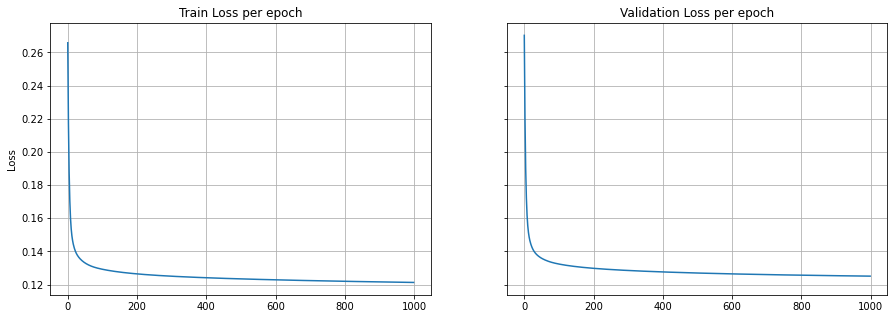

In [9]:
loss_ss = pd.Series(trainer.train_losses[1:])
validations_losses_ss = pd.Series(trainer.val_losses)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

loss_ss.plot(ax=ax[0])
validations_losses_ss.plot(ax=ax[1])
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss per epoch')
ax[1].set_title('Validation Loss per epoch')
ax[0].grid()
ax[1].grid()

#### PREDICTIONS

In [10]:
# validation input and target
inputs, target = frametorch.data_val[:, :-1], frametorch.data_val[:, -1:]
inputs = torch.tensor(inputs, dtype=torch.float32)
target = torch.tensor(target, dtype=torch.float32)

# predictions to pandas
y_pred = quantilenet(inputs)
y_test = pd.Series(target.squeeze().tolist())
y_preds = pd.DataFrame(y_pred.tolist())

#### SCORES 

In [14]:
# final validation loss
quantile_score = criterion(y_pred, target)
print(f'quantile score: {quantile_score}')

# interval score
iscore = IntervalScorePaper(quantiles)
interval_score = iscore.forward(y_pred, target)
print(f'interval score: {interval_score}')

# average coverage error
acerror = AverageCoverageError(quantiles)
avg_cov_error = acerror.forward(y_pred, target)
print(f'average coverage error: {avg_cov_error}')

quantile score: 0.11847244948148727
interval score: (29.04965591430664, 0.29964327812194824)
average coverage error: 0.9289413690567017


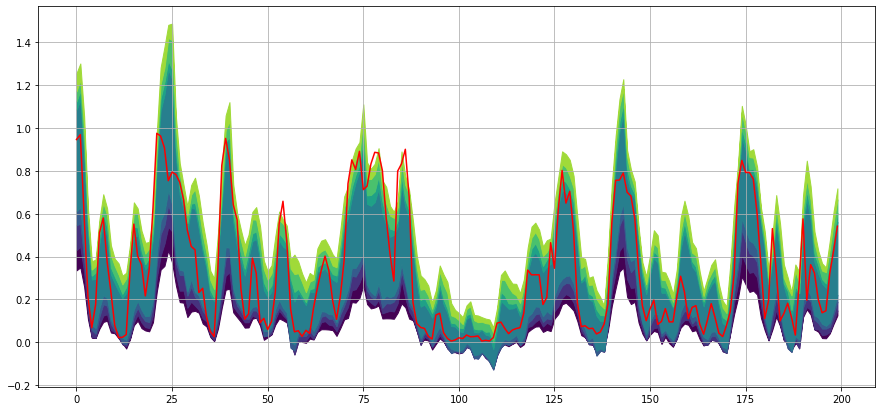

In [16]:
viridis = cm.get_cmap('viridis', len(quantiles))

plt.figure(figsize=(15, 7))

for i in range(len(y_preds.columns)-1):
    plt.fill_between(y_preds.index[:200], y_preds[i][:200], y_preds[i+1][:200], color=viridis.colors[i])

y_test[:200].plot(color='red')
plt.grid()

### 8 MODELS, ONE OUTPUT

In [20]:
# quantiles to predict
quantiles = torch.tensor([0.025, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 0.975])

# number of inputs and outputs
n_inputs = frametorch.data.shape[1] - 1
n_outputs = 1

In [47]:
linear_models = []

for quantile in quantiles:
    # model
    linear_model = LinearNet(n_inputs=n_inputs, n_outputs=n_outputs)
    # criterion to use
    criterion = SmoothPinballLoss(quantile)
    # optimizer
    optimizer = optim.SGD(linear_model.parameters(), lr=0.003)
    # trainer class
    trainer = Trainer(linear_model, criterion, optimizer)

    # train
    linear_model = trainer.fit(train_loader, val_loader, epochs=1000, patience=100)
    linear_models.append(linear_model)

In [42]:
y_preds = []

# validation input and target
inputs, target = frametorch.data_val[:, :-1], frametorch.data_val[:, -1:]
inputs = torch.tensor(inputs, dtype=torch.float32)
target = torch.tensor(target, dtype=torch.float32)
y_test = pd.Series(target.squeeze().tolist())

for linear_model in linear_models:
    # predictions to pandas
    y_pred = linear_model(inputs)
    y_preds.append(y_pred.squeeze().tolist())
    
y_preds = pd.DataFrame(y_preds).T

In [46]:
y_pred = torch.tensor(y_preds.values.tolist(), dtype=torch.float32)

# final validation loss
criterion = SmoothPinballLoss(quantiles)
quantile_score = criterion(y_pred, target)
print(f'quantile score: {quantile_score}')

# interval score
iscore = IntervalScorePaper(quantiles)
interval_score = iscore.forward(y_pred, target)
print(f'interval score: {interval_score}')

# average coverage error
acerror = AverageCoverageError(quantiles)
avg_cov_error = acerror.forward(y_pred, target)
print(f'average coverage error: {avg_cov_error}')

quantile score: 0.1182176023721695
interval score: (29.05245590209961, 0.3024427592754364)
average coverage error: 1.2243151664733887


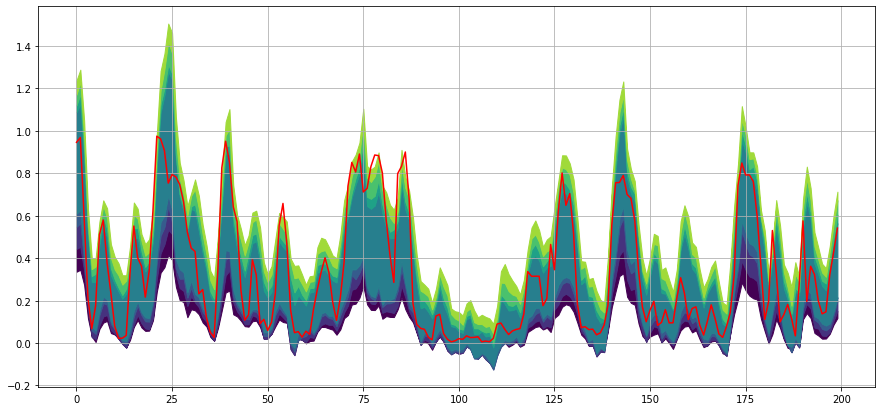

In [35]:
viridis = cm.get_cmap('viridis', len(quantiles))

plt.figure(figsize=(15, 7))

for i in range(len(y_preds.columns)-1):
    plt.fill_between(y_preds.index[:200], y_preds[i][:200], y_preds[i+1][:200], color=viridis.colors[i])

y_test[:200].plot(color='red')
plt.grid()